# Figure 2: detection rates

## Loading the BHNS population

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_LVKO4_duty = table['snr_LVKO4_duty'][()] #SNRs LVK O4
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()] #SNRs LVKI O5

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands = g, z, J
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN abs mag

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time
lc_grb = table['lc_grb'][()] #GRB afterglow flux

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()] #GRB prompt bands
flux_prompt = table['flux_prompt'][()] #GRB prompt photon flux

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


## Weighing the BHNS population

We consider two representative sets of detection limits based on the typical depth that can be reached during an EM follow up in response to a GW alert. For each binary we evaluate if it is GW-, KN-, GRB afterglow- and GRB prompt-detectable.

In [15]:
### --- Limiting Thresholds --- ###
print("O4 detection limits")

lim_snr = 12.
lim_snr_sub = 6.

lim_kn = np.array([22.,22.,21.]) #22 22 21

lim_grb = np.asarray([0.1,5.7e-3,1.5e-6])

lim_prompt_fermi = 4.
lim_prompt_swift = 3.5

#GW
snr_O4 = snr_LVKO4_duty
gw_det_O4 = snr_O4 >= lim_snr
gw_det_O4_sub = snr_O4 >= lim_snr_sub

snr_O5 = snr_LVKIO5_duty
gw_det_O5 = snr_O5 >= lim_snr

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_z = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j,0] >= lim_grb[j]
    grb_det_15[:,j] = grb_peak[:,j,1] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]
grb_det_radio_15 = grb_det_15[:,0]
grb_det_optic_15 = grb_det_15[:,1]
grb_det_x_15 = grb_det_15[:,2]
grb_det_all_15 = np.max(grb_det_15, axis = 1)

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi = flux_prompt[:,0,0] >= lim_prompt_fermi
prompt_det_fermi_15 = flux_prompt[:,0,1] >= lim_prompt_fermi
prompt_det_swift = flux_prompt[:,1,0] >= lim_prompt_swift
prompt_det_swift_15 = flux_prompt[:,1,1] >= lim_prompt_swift 

print("O5 detection limits")

lim_snr_O5 = 12

lim_kn_O5 = np.array([26.,24.4,21.])

lim_grb_O5 = np.asarray([1.e-2,1.5e-4,1.5e-6])

lim_prompt_fermi_O5 = 4.
lim_prompt_swift_O5 = 3.5

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det_O5 = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det_O5[:,j] = kn_peak_APP <= lim_kn_O5[j]
kn_det_all_O5 = np.max(kn_det_O5, axis = 1)
kn_det_g_O5 = kn_det_O5[:,0]
kn_det_z_O5 = kn_det_O5[:,1]
kn_det_J_O5 = kn_det_O5[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det_O5 = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_O5_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det_O5[:,j] = grb_peak[:,j,0] >= lim_grb_O5[j]
    grb_det_O5_15[:,j] = grb_peak[:,j,1] >= lim_grb_O5[j]
grb_det_all_O5 = np.max(grb_det_O5, axis = 1)
grb_det_radio_O5 = grb_det_O5[:,0]
grb_det_optic_O5 = grb_det_O5[:,1]
grb_det_x_O5 = grb_det_O5[:,2]
grb_det_radio_O5_15 = grb_det_O5_15[:,0]
grb_det_optic_O5_15 = grb_det_O5_15[:,1]
grb_det_x_O5_15 = grb_det_O5_15[:,2]

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi_O5 = flux_prompt[:,0,0] >= lim_prompt_fermi_O5
prompt_det_fermi_O5_15 = flux_prompt[:,0,1] >= lim_prompt_fermi_O5
prompt_det_swift_O5 = flux_prompt[:,0,0] >= lim_prompt_swift_O5
prompt_det_swift_O5_15 = flux_prompt[:,0,1] >= lim_prompt_swift_O5

O4 detection limits
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
O5 detection limits
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds


## Detection rates

In [17]:
x = np.sort(z)
s = np.argsort(z)

### --- Computing detection Rates in O4--- ###

#ALL NSNS
cum_tot = C_mc*np.cumsum(w[s])
cum_tot_high = C_mc_high*np.cumsum(w_high[s])
cum_tot_low = C_mc_low*np.cumsum(w_low[s])

#GW O4
cum_gw_O4 = C_mc*np.cumsum(w[s]*gw_det_O4[s])
cum_gw_O4_high = C_mc_high*np.cumsum(w_high[s]*gw_det_O4[s])
cum_gw_O4_low = C_mc_low*np.cumsum(w_low[s]*gw_det_O4[s])
cum_gw_O4_norm = cum_gw_O4/cum_gw_O4[-1]

#KN O4
cum_gw_kn = C_mc*np.cumsum(w[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_high = C_mc_high*np.cumsum(w_high[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_low = C_mc_low*np.cumsum(w_low[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z = C_mc*np.cumsum(w[s]*kn_det_z[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z_high = C_mc_high*np.cumsum(w_high[s]*kn_det_z[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z_low = C_mc_low*np.cumsum(w_low[s]*kn_det_z[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_high = C_mc_high*np.cumsum(w_high[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_low = C_mc_low*np.cumsum(w_low[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]

#GRB AFTERGLOW O4
cum_gw_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_15 =  C_mc*np.cumsum(w[s]*grb_det_all_15[s]*gw_det_O4[s])
cum_gw_grb_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_O4[s])  
cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det_O4[s])
cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det_O4[s])  
cum_gw_grb_radio_15 =  C_mc*np.cumsum(w[s]*grb_det_radio_15[s]*gw_det_O4[s])  
cum_gw_grb_radio_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_15[s]*gw_det_O4[s])
cum_gw_grb_radio_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_15[s]*gw_det_O4[s])  
cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det_O4[s])
cum_gw_grb_optic_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic[s]*gw_det_O4[s])
cum_gw_grb_optic_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic[s]*gw_det_O4[s])
cum_gw_grb_optic_15 =  C_mc*np.cumsum(w[s]*grb_det_optic_15[s]*gw_det_O4[s])
cum_gw_grb_optic_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic_15[s]*gw_det_O4[s])
cum_gw_grb_optic_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic_15[s]*gw_det_O4[s])
cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det_O4[s])   
cum_gw_grb_x_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_x[s]*gw_det_O4[s])
cum_gw_grb_x_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_x[s]*gw_det_O4[s])
cum_gw_grb_x_15 =  C_mc*np.cumsum(w[s]*grb_det_x_15[s]*gw_det_O4[s])   
cum_gw_grb_x_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_x_15[s]*gw_det_O4[s])
cum_gw_grb_x_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_x_15[s]*gw_det_O4[s])
cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]
    
#GRB PROMPT O4
cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_O4[s])
cum_gw_fermi_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_15[s]*gw_det_O4[s])
cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det_O4[s])
cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det_O4[s])
cum_gw_fermi_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_15[s]*gw_det_O4[s])
cum_gw_fermi_low_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_15[s]*gw_det_O4[s])
cum_gw_fermi_sub = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_O4_sub[s])
cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]
cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s]*gw_det_O4[s])
cum_gw_swift_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_swift[s]*gw_det_O4[s])
cum_gw_swift_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift[s]*gw_det_O4[s])
cum_gw_swift_15 = C_mc*np.cumsum(w[s]*prompt_det_swift_15[s]*gw_det_O4[s])
cum_gw_swift_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_swift_15[s]*gw_det_O4[s])
cum_gw_swift_low_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift_15[s]*gw_det_O4[s])

### --- Computing detection Rates in O5--- ###

#GW O5
cum_gw_O5 = C_mc*np.cumsum(w[s]*gw_det_O5[s])
cum_gw_small_O5 = C_mc*np.cumsum(w[s]*gw_det_O5[s]*(mbh[s]<5.))
cum_gw_high_O5 = C_mc_high*np.cumsum(w_high[s]*gw_det_O5[s])
cum_gw_low_O5 = C_mc_low*np.cumsum(w_low[s]*gw_det_O5[s])
cum_gw_norm_O5 = cum_gw_O5/cum_gw_O5[-1]

#KN O5
cum_gw_kn_O5 = C_mc*np.cumsum(w[s]*kn_det_all_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_all_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_all_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))  
cum_gw_kn_g_O5 = C_mc*np.cumsum(w[s]*kn_det_g_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_g_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_g_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_g_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_z_O5 = C_mc*np.cumsum(w[s]*kn_det_z_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_z_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_z_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_z_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_J_O5 = C_mc*np.cumsum(w[s]*kn_det_J_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_J_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_J_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_J_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_g_norm_O5 = cum_gw_kn_g_O5/cum_gw_kn_g_O5[-1]

#GRB AFTERGLOW  O5
cum_gw_grb_O5 =  C_mc*np.cumsum(w[s]*grb_det_all_O5[s]*gw_det_O5[s])
cum_gw_grb_radio_O5 =  C_mc*np.cumsum(w[s]*grb_det_radio_O5[s]*gw_det_O5[s])  
cum_gw_grb_radio_high_O5 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_O5[s]*gw_det_O5[s])   
cum_gw_grb_radio_low_O5 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_O5[s]*gw_det_O5[s]) 
cum_gw_grb_radio_O5_15 =  C_mc*np.cumsum(w[s]*grb_det_radio_O5_15[s]*gw_det_O5[s])  
cum_gw_grb_radio_high_O5_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_radio_low_O5_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_O5_15[s]*gw_det_O5[s])  
cum_gw_grb_optic_O5 =  C_mc*np.cumsum(w[s]*grb_det_optic_O5[s]*gw_det_O5[s])
cum_gw_grb_optic_high_O5 =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic_O5[s]*gw_det_O5[s])   
cum_gw_grb_optic_low_O5 =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic_O5[s]*gw_det_O5[s])  
cum_gw_grb_optic_O5_15 =  C_mc*np.cumsum(w[s]*grb_det_optic_O5_15[s]*gw_det_O5[s])
cum_gw_grb_optic_high_O5_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_optic_low_O5_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_x_O5 =  C_mc*np.cumsum(w[s]*grb_det_x_O5[s]*gw_det_O5[s])
cum_gw_grb_x_high_O5 =  C_mc_high*np.cumsum(w_high[s]*grb_det_x_O5[s]*gw_det_O5[s])   
cum_gw_grb_x_low_O5 =  C_mc_low*np.cumsum(w_low[s]*grb_det_x_O5[s]*gw_det_O5[s])
cum_gw_grb_x_O5_15 =  C_mc*np.cumsum(w[s]*grb_det_x_O5_15[s]*gw_det_O5[s])
cum_gw_grb_x_high_O5_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_x_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_x_low_O5_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_x_O5_15[s]*gw_det_O5[s])
cum_gw_grb_radio_norm_O5 = cum_gw_grb_radio_O5/cum_gw_grb_radio_O5[-1]

#GRB PROMPT O5
cum_gw_fermi_O5 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_fermi_high_O5= C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_fermi_low_O5 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_fermi_O5_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_fermi_high_O5_15= C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_fermi_low_O5_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_fermi_norm_O5 = cum_gw_fermi_O5/cum_gw_fermi_O5[-1]
cum_gw_swift_O5 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_swift_high_O5= C_mc_high*np.cumsum(w_high[s]*prompt_det_swift_O5[s]*gw_det_O5[s])
cum_gw_swift_low_O5 = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift_O5[s]*gw_det_O5[s])
cum_gw_swift_O5_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_swift_high_O5_15= C_mc_high*np.cumsum(w_high[s]*prompt_det_swift_O5_15[s]*gw_det_O5[s])
cum_gw_swift_low_O5_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift_O5_15[s]*gw_det_O5[s])


Plotting detection rates O4
Plotting detection rates O5


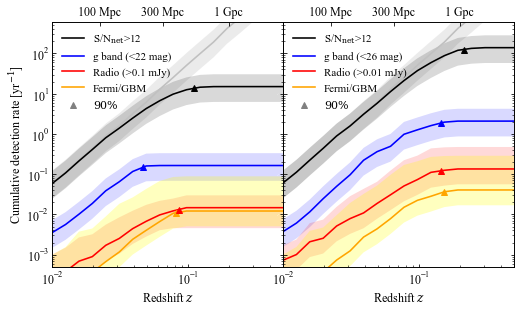

In [21]:

plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=7.5,4.5
plt.rcParams['mathtext.fontset']='dejavuserif'

gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(1,2,gridspec_kw=gs_kw) 

skip = 30000

### --- Plotting detection rates O4 --- ###

print("Plotting detection rates O4")

ax[0].loglog(x[::skip],cum_tot[::skip],c='silver',linewidth=1.6,zorder=1)
ax[0].fill_between(x[::skip],cum_tot_high[::skip],cum_tot_low[::skip],color='silver',alpha=0.3,edgecolor="None",zorder=1)

ax[0].loglog(x[::skip],cum_gw_O4[::skip],c='black',linestyle='-',linewidth=1.6,zorder=1, label = "S/N$_\mathrm{net}$>12")
ax[0].loglog(x[::skip],cum_gw_kn_g[::skip],c='blue',linewidth=1.6,zorder=1, label="g band (<22 mag)")
ax[0].loglog(x[::skip],cum_gw_grb_radio[::skip],c='red',linewidth=1.6,zorder=1,ls="-",label="Radio (>0.1 mJy)")
ax[0].loglog(x[::skip],cum_gw_fermi[::skip]*0.6,ls="-",c='orange',linewidth=1.6,zorder=1, label="Fermi/GBM")
ax[0].fill_between(x[::skip],cum_gw_O4_high[::skip],cum_gw_O4_low[::skip],color='black',alpha=0.15,edgecolor="None",zorder=1)
ax[0].fill_between(x[::skip],cum_gw_kn_g_high[::skip],cum_gw_kn_g_low[::skip],color='blue',alpha=0.15,edgecolor="None",zorder=1)
ax[0].fill_between(x[::skip],np.maximum(cum_gw_grb_radio_high[::skip],cum_gw_grb_radio_high_15[::skip]),np.minimum(cum_gw_grb_radio_low[::skip],cum_gw_grb_radio_low_15[::skip]),color='red',alpha=0.15,edgecolor="None",zorder=1)
ax[0].fill_between(x[::skip],np.maximum(cum_gw_fermi_high[::skip]*0.6,cum_gw_fermi_high_15[::skip]*0.6),np.minimum(cum_gw_fermi_low[::skip]*0.6,cum_gw_fermi_low_15[::skip]*0.6),color='yellow',alpha=0.25,edgecolor="None",zorder=1)

perc = 0.9
xgw = np.interp(perc,cum_gw_O4_norm[::skip],x[::skip])
ygw = np.interp(np.interp(perc,cum_gw_O4_norm[::skip],x[::skip]),x[::skip],cum_gw_O4[::skip])
xkn = np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip])
ykn = np.interp(np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip]),x[::skip],cum_gw_kn_g[::skip])
xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
yfermi = np.interp(np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip]),x[::skip],cum_gw_fermi[::skip]*0.6)
xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
ygrb = np.interp(np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip]),x[::skip],cum_gw_grb_radio[::skip])

ax[0].errorbar(xgw,ygw,c='black',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(xkn,ykn,c='blue',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(xfermi,yfermi,ls="-",c='orange',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(xgrb,ygrb,ls="-",c='red',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(4,10000000,c='grey',marker='^',linestyle='None',elinewidth=1,capsize=2,label=r"$90\%$")

ylim = (5.e-4,600.)
xlim = (0.01,0.5)

ax[0].legend(loc=2,frameon=False,prop={'size': 11})

ax[0].set_xlabel('Redshift $z$',size=12)
ax[0].set_ylabel(r'Cumulative detection rate [yr$^{-1}$]',size=12)
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
ax[0].set_xticks([0.01,0.1])
ax[0].set_xticklabels(('0.01','0.1'),size=12)
ax[0].minorticks_on()
ax2 = ax[0].twiny()
ax2.set_xlim(xlim)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_off()
ax2.set_xticks([0.02225,0.0647,0.198])
ax2.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)

ax[0].tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
ax2.tick_params(direction='in',which='both',zorder=2)
ax[0].yaxis.labelpad = 0.1

ax[0].set_yscale('log')
ax[0].set_xscale('log')

### --- Plotting detection rates O5 --- ###

print("Plotting detection rates O5")

ax[1].loglog(x[::skip],cum_tot[::skip],c='silver',linewidth=1.6,zorder=1)
ax[1].loglog(x[::skip],cum_gw_O5[::skip],c='black',linestyle='-',linewidth=1.6,zorder=1,label="S/N$_\mathrm{net}$>12")
ax[1].loglog(x[::skip],cum_gw_kn_g_O5[::skip],c='blue',linewidth=1.6,zorder=1,label="g band (<26 mag)")
ax[1].loglog(x[::skip],cum_gw_grb_radio_O5[::skip],c='red',ls='-',linewidth=1.6,zorder=1,label="Radio (>0.01 mJy)")
ax[1].loglog(x[::skip],cum_gw_fermi_O5[::skip]*0.6,c='orange',ls="-",linewidth=1.6,zorder=1,label="Fermi/GBM")

ax[1].fill_between(x[::skip],cum_tot_high[::skip],cum_tot_low[::skip],color='silver',alpha=0.3,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],cum_gw_high_O5[::skip],cum_gw_low_O5[::skip],color='black',alpha=0.15,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],cum_gw_kn_g_high_O5[::skip],cum_gw_kn_g_low_O5[::skip],color='blue',alpha=0.15,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],np.maximum(cum_gw_grb_radio_high_O5[::skip],cum_gw_grb_radio_high_O5_15[::skip]),np.minimum(cum_gw_grb_radio_low_O5[::skip],cum_gw_grb_radio_low_O5_15[::skip]),color='red',alpha=0.15,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],np.maximum(cum_gw_fermi_high_O5[::skip]*0.6,cum_gw_fermi_high_O5_15[::skip]*0.6),np.minimum(cum_gw_fermi_low_O5[::skip]*0.6,cum_gw_fermi_low_O5_15[::skip]*0.6),color='yellow',alpha=0.25,edgecolor="None",zorder=1)

xgw = np.interp(0.9,cum_gw_norm_O5[::skip],x[::skip])
ygw = np.interp(np.interp(0.9,cum_gw_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_O5[::skip])
xkn = np.interp(0.9,cum_gw_kn_g_norm_O5[::skip],x[::skip])
ykn = np.interp(np.interp(0.9,cum_gw_kn_g_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_kn_g_O5[::skip])
xfermi = np.interp(0.9,cum_gw_fermi_norm_O5[::skip],x[::skip])
yfermi = np.interp(np.interp(0.9,cum_gw_fermi_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_fermi_O5[::skip]*0.6)
xgrb = np.interp(0.9,cum_gw_grb_radio_norm_O5[::skip],x[::skip])
ygrb = np.interp(np.interp(0.9,cum_gw_grb_radio_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_grb_radio_O5[::skip])

ax[1].errorbar(xgw,ygw,c='black',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(xkn,ykn,c='blue',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(xfermi,yfermi,ls="-",c='orange',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(xgrb,ygrb,ls="-",c='red',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(4,10000000,c='grey',marker='^',linestyle='None',elinewidth=1,capsize=2,label=r"$90\%$")


ax[1].legend(loc=2,frameon=False,prop={'size': 11})

ax[1].set_xlabel('Redshift $z$',size=12)
ax[1].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_xticks([0.01,0.1])
ax[1].set_xticklabels(('0.01','0.1'),size=12)
ax[1].set_yticks([])
ax[1].tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=0,labelcolor="white",zorder=2)
ax[1].tick_params(axis = 'x',direction='in',which='both',labelsize=12)
ax3 = ax[1].twiny()
ax3.set_xlim(xlim)
ax3.set_xscale('log')
ax3.minorticks_off()
ax3.set_xticks([0.02225,0.0647,0.198])
ax3.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)
fig1.subplots_adjust(wspace=0.,right=0.98)
ax3.tick_params(direction='in',which='both',zorder=2)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.show()